# GLM-Infused SweetNet Experiments

Experimenting with a modified version of SweetNet that allows it to take pre-trained embeddings as input. To get there I need a way to take the embeddings I’ve gotten from roman and transform them into nice inputs for the model, and a way to set the initial features using these inputs. 


## Importing and exploring the GLM Embedding data

In [ ]:
# quick thing to load a pickle file

import pickle
import os # To check if file exists

pickle_file_path = 'glm_embeddings_1.pkl'

# --- Load the Pickle File ---
if os.path.exists(pickle_file_path):
    print(f"Loading embeddings from: {pickle_file_path}")
    try:
        # Open the file in binary read mode ('rb')
        with open(pickle_file_path, 'rb') as file_handle:
            # Load the object(s) from the pickle file
            loaded_embeddings = pickle.load(file_handle)

        print("Embeddings loaded successfully!")        

    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"Error: File not found at '{pickle_file_path}'. Please check the filename and path.")

In [ ]:
# lets do some quick exploration

# --- Explore the loaded data ---
print(f"Type of loaded object: {type(loaded_embeddings)}")

# Common formats for embeddings: dictionary or numpy array
if isinstance(loaded_embeddings, dict):
    print(f"Number of items (if dictionary): {len(loaded_embeddings)}")
    # print some keys to see what they look like
    print(f"Example keys (first 5): {list(loaded_embeddings.keys())[:5]}")
elif hasattr(loaded_embeddings, 'shape'):
    print(f"Shape (if array/tensor): {loaded_embeddings.shape}")
    if hasattr(loaded_embeddings, 'dtype'):
         print(f"Data type (if array/tensor): {loaded_embeddings.dtype}")

In [ ]:
print(list(loaded_embeddings.keys())[5:30]) # Print more keys

In [ ]:
example_key = '!GlcNAc' 
if example_key in loaded_embeddings:
    embedding_vector = loaded_embeddings[example_key]
    print(f"Type of value for '{example_key}': {type(embedding_vector)}")
    if hasattr(embedding_vector, 'shape'):
        print(f"Shape of value: {embedding_vector.shape}") # This gives dimensionality!
        print(f"Dtype of value: {embedding_vector.dtype}")
    print(embedding_vector) # Print the vector itself if it's not too long
else:
    print(f"Key '{example_key}' not found.")

In [ ]:
# let's look at the keys a bit more closely

import collections

key_types = collections.defaultdict(int)
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        key_types['linkage_or_modification'] += 1
    elif key[0].isalpha():
        key_types['monosaccharide'] += 1
    else:
        key_types['other'] += 1

print(key_types)

In [ ]:
# Let's explore those Other keys 

other_keys = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        pass # linkage_or_modification
    elif key[0].isalpha():
        pass # monosaccharide
    else:
        other_keys.append(key)

print(f"Number of 'other' keys: {len(other_keys)}")
print(f"Examples of 'other' keys: {other_keys[:20]}") # Print the first 20

In [ ]:
# Let's look at 50 more keys

print(f"More Examples of 'other' keys: {other_keys[20:70]}")

In [ ]:
# Let's explore those monosaccharide keys
monosaccharide = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        pass # linkage_or_modification
    elif key[0].isalpha():
        monosaccharide.append(key)
    else:
        pass # other

print(f"Number of 'monosaccharide' keys: {len(monosaccharide)}")
print(f"Examples of 'monosaccharide' keys: {monosaccharide[:50]}") # Print the first 50

In [ ]:
# To be throughough, let's look at 50 Linkage or Modification keys as well
linkage_or_modification = []
for key in loaded_embeddings.keys():
    if '-' in key and not any(char.isalpha() for char in key):
        linkage_or_modification.append(key)
    elif key[0].isalpha():
        pass # monosaccharide
    else:
        pass # other

print(f"Number of 'linkage_or_modification' keys: {len(linkage_or_modification)}")
print(f"Examples of 'linkage_or_modification' keys: {linkage_or_modification[:50]}") # Print the first 50

### Load the glycowork library

I'll load the glycowork library and compare it to the keys in the embedding file

In [ ]:
from glycowork.glycan_data import loader

glycowork_vocabulary = loader.lib

print(f"Number of items in glycowork vocabulary: {len(glycowork_vocabulary)}")
print(f"Example keys from glycowork vocabulary (first 20): {list(glycowork_vocabulary.keys())[:20]}")

Nice, they seem to correspond one to one!

That saves me a lot of work down the line (Thanks Roman)

In [ ]:
# let's look at one of the keys in the glycowork vocabulary to see what they return
example_glycowork_key = '-10'
if example_glycowork_key in glycowork_vocabulary:
    glycowork_value = glycowork_vocabulary[example_glycowork_key]
    print(f"Type of value for '{example_glycowork_key}': {type(glycowork_value)}")
    print(glycowork_value)   

### Filter and Transform Data

In [ ]:
#Loads the GIFFLAR dataset for the Taxonomy Kingdom (takes a long time to run(~40m), just use the file it generated)

import sys
sys.path.append('../GIFFLAR') 

from gifflar.benchmarks import get_dataset
import pathlib

data_config_kingdom = {"name": "Taxonomy_Kingdom"}
root_dir = pathlib.Path("./data_gifflar")  # Choose a directory to save the data
root_dir.mkdir(exist_ok=True, parents=True)

kingdom_dataset_config = get_dataset(data_config_kingdom, root_dir)


In [ ]:
# Print the dataset configuration
print(kingdom_dataset_config)



In [2]:
# Lets load the dataset into a pandas dataframe
import pandas as pd

filepath = 'data_gifflar/taxonomy_Kingdom.tsv'
#filepath = kingdom_dataset_config['filepath'] #If you've loaded it recently, which you shouldn't

# Load the dataset into a pandas DataFrame
multilabel_kingdom_df = pd.read_csv(filepath, sep="\t")
# Display the first few rows of the DataFrame
print(multilabel_kingdom_df.head())
# Display the shape of the DataFrame
print(f"Shape of the DataFrame: {multilabel_kingdom_df.shape}")

                                               IUPAC  Amoebozoa  Animalia  \
0  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
1  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
2  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
3  3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-...          0         0   
4  3,6-Anhydro-L-Gal(a1-3)GalOMe(b1-4)3,6-Anhydro...          0         0   

   Bacteria  Bamfordvirae  Chromista  Euryarchaeota  Excavata  Fungi  \
0         1             0          0              0         0      0   
1         1             0          0              0         0      0   
2         1             0          0              0         0      0   
3         1             0          0              0         0      0   
4         1             0          0              0         0      0   

   Heunggongvirae  Metazoa  Orthornavirae  Pararnavirae  Plantae  Protista  \
0               0        0

That looks fine

Let's convert them into graphs

In [ ]:
print(multilabel_kingdom_df.columns)

In [3]:

# Let's try the prepare multilabel function from the train_test_split module

from glycowork.ml.train_test_split import prepare_multilabel

# Prepare the multilabel dataset using the melt function
# The melt function is used to transform the DataFrame from wide format to long format
kingdom_df_melted = multilabel_kingdom_df.melt(
    id_vars=['IUPAC', 'split'],
    value_vars=['Amoebozoa', 'Animalia', 'Bacteria', 'Bamfordvirae', 'Chromista', 'Euryarchaeota', 'Excavata', 'Fungi', 'Heunggongvirae', 'Metazoa', 'Orthornavirae', 'Pararnavirae', 'Plantae', 'Protista', 'Riboviria'],
    var_name='Kingdom',
    value_name='Association'
)

# Filter for associations where the glycan belongs to the kingdom (Association == 1)
kingdom_df_melted = kingdom_df_melted[kingdom_df_melted['Association'] == 1]

# Splitting the dataset using the 'split' column
train_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'train'].drop(columns=['split'])
val_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'val'].drop(columns=['split'])
test_melted_df = kingdom_df_melted[kingdom_df_melted['split'] == 'test'].drop(columns=['split'])

# Finally using the prepare_multilabel function to prepare the data for training
glycan_train, label_train = prepare_multilabel(train_melted_df, rank='Kingdom', glycan_col='IUPAC')
glycan_val, label_val = prepare_multilabel(val_melted_df, rank='Kingdom', glycan_col='IUPAC')
glycan_test, label_test = prepare_multilabel(test_melted_df, rank='Kingdom', glycan_col='IUPAC')



In [4]:
# Let's validate the split

import pandas as pd
import numpy as np

# 1. Load the original DataFrame
multilabel_kingdom_df_original = pd.read_csv(filepath, sep="\t")
kingdom_cols = ['Amoebozoa', 'Animalia', 'Bacteria', 'Bamfordvirae', 'Chromista', 'Euryarchaeota', 'Excavata', 'Fungi', 'Heunggongvirae', 'Metazoa', 'Orthornavirae', 'Pararnavirae', 'Plantae', 'Protista', 'Riboviria']

# 2. Split the original DataFrame by 'split'
train_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'train']
val_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'val']
test_df = multilabel_kingdom_df_original[multilabel_kingdom_df_original['split'] == 'test']

# 3. Extract glycans and labels directly
glycan_train_list = train_df['IUPAC'].tolist()
label_train_list = [train_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_train_list = list(zip(*label_train_list)) # Transpose

glycan_val_list = val_df['IUPAC'].tolist()
label_val_list = [val_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_val_list = list(zip(*label_val_list)) # Transpose

glycan_test_list = test_df['IUPAC'].tolist()
label_test_list = [test_df[kingdom].values.tolist() for kingdom in kingdom_cols]
label_test_list = list(zip(*label_test_list)) # Transpose

print(f"Number of training glycans: {len(glycan_train_list)}")
print(f"Number of validation glycans: {len(glycan_val_list)}")
print(f"Number of test glycans: {len(glycan_test_list)}")
print(f"Shape of training labels: {len(label_train_list)} x {len(label_train_list[0]) if label_train_list else 0}")
print(f"Shape of validation labels: {len(label_val_list)} x {len(label_val_list[0]) if label_val_list else 0}")
print(f"Shape of test labels: {len(label_test_list)} x {len(label_test_list[0]) if label_test_list else 0}")

# Now re-run the checking function (modified for this new label extraction)
def check_example_direct(glycan_list, label_list, split_name, original_df, kingdom_cols):
    if glycan_list:
        example_index = 0
        example_glycan = glycan_list[example_index]
        example_labels_split = list(label_list[example_index])

        original_row = original_df[original_df['IUPAC'] == example_glycan].iloc[0]
        labels_original = np.array([original_row[col] for col in kingdom_cols], dtype=np.float32).tolist()

        print(f"--- Checking example from {split_name} set (Direct) ---")
        print(f"Glycan: {example_glycan}")
        print(f"Split in original data: {original_row['split']}")
        print(f"Labels in split data: {example_labels_split}")
        print(f"Labels in original data: {labels_original}")
        if labels_original == example_labels_split:
            print("Labels match!")
        else:
            print("Labels DO NOT match!")
    else:
        print(f"{split_name} set is empty.")

check_example_direct(glycan_train_list, label_train_list, 'train', multilabel_kingdom_df_original, kingdom_cols)
check_example_direct(glycan_val_list, label_val_list, 'val', multilabel_kingdom_df_original, kingdom_cols)
check_example_direct(glycan_test_list, label_test_list, 'test', multilabel_kingdom_df_original, kingdom_cols)

Number of training glycans: 11593
Number of validation glycans: 3213
Number of test glycans: 1646
Shape of training labels: 11593 x 15
Shape of validation labels: 3213 x 15
Shape of test labels: 1646 x 15
--- Checking example from train set (Direct) ---
Glycan: 3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-Gal(a1-3)Gal
Split in original data: train
Labels in split data: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Labels in original data: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Labels match!
--- Checking example from val set (Direct) ---
Glycan: 3,6-Anhydro-L-Gal(a1-3)Gal(b1-4)3,6-Anhydro-L-Gal(a1-3)GalOMe(b1-4)3,6-Anhydro-L-Gal(a1-3)Gal
Split in original data: val
Labels in split data: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Labels in original data: [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Labels match!
--- Checking example from test set (Direct) ---
Glycan: 3,6-Anhydro-L-Gal(a1-3)GalOMe(b1-4)3,6-Anhydro-L-G

In [5]:
# Lets make them into graphs again, but hyper efficiently this time

from glycowork.ml.processing import split_data_to_train

multilabel_kingdom_loaders = split_data_to_train(
    glycan_list_train=glycan_train,
    glycan_list_val=glycan_val,
    labels_train=label_train,
    labels_val=label_val,
    batch_size=32,  # Adjust as needed
    drop_last=False,
    augment_prob=0.0,  # Adjust if you want augmentation for training
    generalization_prob=0.0  # Adjust if you want generalization for training
)


In [ ]:
print(multilabel_kingdom_loader)

Batch: DataBatch(edge_index=[2, 430], labels=[462], string_labels=[32], y=[480], num_nodes=462, x=[462, 320], batch=[462], ptr=[33])
Number of graphs in batch: 32

First graph data: Data(edge_index=[2, 8], labels=[9], string_labels=[9], y=[15], x=[9, 320], num_nodes=9)
Node features (x): tensor([[ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        ...,
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676],
        [ 0.9339, -0.7572, -0.5228,  ...,  1.8300,  0.1645,  1.2676]])
Edge indices (edge_index): tensor([[1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7]])
Labels (y): tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
String labels: ['Rha', 'a1-3', 'Rha', 'a1-4', 'GalNAcA3Ac', 'a1-3', 'QuiNAc', 'b1-2', 'Rha']


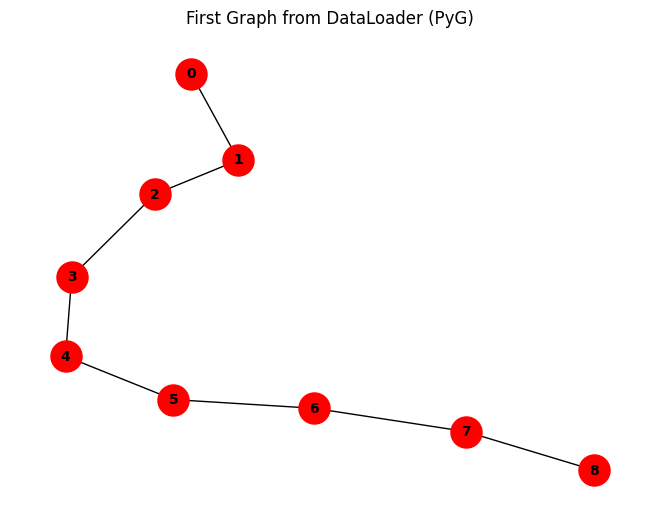

In [10]:
# Check one of the graphs in the dataloader

import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Assuming your DataLoader is called 'multilabel_kingdom_loader'
inspected_loader = multilabel_kingdom_loaders_emb['train'] # Access the train DataLoader

# Get the first batch of data
try:
    batch = next(iter(inspected_loader))
    print("Batch:", batch)
    print("Number of graphs in batch:", batch.num_graphs)

    # Extract the first graph from the batch
    first_graph_data = batch[2] #change to check other graphs
    print("\nFirst graph data:", first_graph_data)
    print("Node features (x):", first_graph_data.x)
    print("Edge indices (edge_index):", first_graph_data.edge_index)
    print("Labels (y):", first_graph_data.y)
    print("String labels:", first_graph_data.string_labels)

    # Convert the PyG Data object to a NetworkX graph for visualization
    nx_graph = to_networkx(first_graph_data) 

    # Visualize the NetworkX graph
    nx_graph = to_networkx(first_graph_data)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color="red", font_size=10, font_weight="bold", arrows=False)
    plt.title("First Graph from DataLoader (PyG)")
    plt.show()

except StopIteration:
    print("The DataLoader is empty.")
except Exception as e:
    print(f"An error occurred: {e}")

## Let's make a function to add embeddings to a dataloader object

In [7]:
# Let's load the embeddings again here, so I don't have to jump up and down whenever I reload the kernel)

import pickle
import os # To check if file exists

pickle_file_path = 'glm_embeddings_1.pkl'

# --- Load the Pickle File ---
if os.path.exists(pickle_file_path):
    print(f"Loading embeddings from: {pickle_file_path}")
    try:
        # Open the file in binary read mode ('rb')
        with open(pickle_file_path, 'rb') as file_handle:
            # Load the object(s) from the pickle file
            glm_embeddings = pickle.load(file_handle)

        print("Embeddings loaded successfully!")        

    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")
else:
    print(f"Error: File not found at '{pickle_file_path}'. Please check the filename and path.")

Loading embeddings from: glm_embeddings_1.pkl
Embeddings loaded successfully!


In [8]:
# Function to add GLM embeddings to a dictionary of dataloaders before loading them into the model

import torch
from torch_geometric.loader import DataLoader

def add_glm_embeddings_to_dataloaders(dataloaders, glm_embeddings):
    embedded_loaders = {}
    embedding_dim = 320
    for split, loader in dataloaders.items():
        embedded_data_list = []
        for batch in loader:
            for graph in batch.to_data_list():
                node_embeddings = []
                if hasattr(graph, 'string_labels'):
                    for label in graph.string_labels:
                        if label in glm_embeddings:
                            node_embeddings.append(torch.tensor(glm_embeddings[label]))
                        else:
                            node_embeddings.append(torch.zeros(embedding_dim))
                    graph.x = torch.stack(node_embeddings).float()
                    print(f"Shape of graph.x after adding embeddings: {graph.x.shape}")
                embedded_data_list.append(graph)

        embedded_loaders[split] = DataLoader(embedded_data_list, batch_size=32)
        print(f"GLM embeddings added to {split} DataLoader.")
    return embedded_loaders

In [9]:
# testing the fucntion

multilabel_kingdom_loaders_emb = add_glm_embeddings_to_dataloaders(multilabel_kingdom_loaders, glm_embeddings)

Shape of graph.x after adding embeddings: torch.Size([17, 320])
Shape of graph.x after adding embeddings: torch.Size([7, 320])
Shape of graph.x after adding embeddings: torch.Size([9, 320])
Shape of graph.x after adding embeddings: torch.Size([21, 320])
Shape of graph.x after adding embeddings: torch.Size([5, 320])
Shape of graph.x after adding embeddings: torch.Size([17, 320])
Shape of graph.x after adding embeddings: torch.Size([5, 320])
Shape of graph.x after adding embeddings: torch.Size([7, 320])
Shape of graph.x after adding embeddings: torch.Size([27, 320])
Shape of graph.x after adding embeddings: torch.Size([41, 320])
Shape of graph.x after adding embeddings: torch.Size([17, 320])
Shape of graph.x after adding embeddings: torch.Size([23, 320])
Shape of graph.x after adding embeddings: torch.Size([19, 320])
Shape of graph.x after adding embeddings: torch.Size([11, 320])
Shape of graph.x after adding embeddings: torch.Size([3, 320])
Shape of graph.x after adding embeddings: torc

In [ ]:
L

## SweetNet copy from models.py for experimentation

In [ ]:
# SweetNet class

from typing import Dict, Optional, Tuple, Union, Literal

import numpy as np
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.nn import GraphConv
    from torch_geometric.nn import global_mean_pool as gap
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
except ImportError:
  raise ImportError("<torch or torch_geometric missing; did you do 'pip install glycowork[ml]'?>")
from glycowork.glycan_data.loader import lib, download_model 

class SweetNet(torch.nn.Module):
    def __init__(self, lib_size: int, # number of unique tokens for graph nodes
                 num_classes: int = 1, # number of output classes (>1 for multilabel)
                 hidden_dim: int = 128, # dimension of hidden layers
                 use_external_embeddings: bool = False # whether to use external embeddings (GLM or other)
                ) -> None:
        "given glycan graphs as input, predicts properties via a graph neural network"
        #print("Using SweetNet from notebook cell!") # Check to see if I am running this in the notebook
        super(SweetNet, self).__init__()
        self.use_external_embeddings = use_external_embeddings
        # Convolution operations on the graph
        self.conv1 = GraphConv(hidden_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)

        # Node embedding
        if use_external_embeddings:
            self.embedding_dim = hidden_dim
        else:
            self.item_embedding = torch.nn.Embedding(num_embeddings=lib_size+1, embedding_dim=hidden_dim)

 

        #self.item_embedding = torch.nn.Embedding(num_embeddings=lib_size+1, embedding_dim=hidden_dim)

        # Fully connected part
        self.lin1 = torch.nn.Linear(hidden_dim, 1024)
        self.lin2 = torch.nn.Linear(1024, 128)
        self.lin3 = torch.nn.Linear(128, num_classes)
        self.bn1 = torch.nn.BatchNorm1d(1024)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.act1 = torch.nn.LeakyReLU()
        self.act2 = torch.nn.LeakyReLU()

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor,
                inference: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        
        # Getting node features
        if self.use_external_embeddings:
           # Use external embeddings (already in x)
            pass # x is already the embeddings
        else:
             # Use internal embedding
            x = self.item_embedding(x).squeeze(1)
            
        
        # Graph convolution operations (now using GLM embeddings as x)
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = gap(x, batch)

        # Fully connected part
        x = self.act1(self.bn1(self.lin1(x)))
        x_out = self.bn2(self.lin2(x))
        x = F.dropout(self.act2(x_out), p = 0.5, training = self.training)

        x = self.lin3(x).squeeze(1)

        if inference:
          return x, x_out
        else:
          return x



### Other functions I might modify

In [13]:
# Init_weights function

def init_weights(model: torch.nn.Module, # neural network for analyzing glycans
                mode: str = 'sparse', # initialization algorithm: 'sparse', 'kaiming', 'xavier'
                sparsity: float = 0.1 # proportion of sparsity after initialization
               ) -> None:
    "initializes linear layers of PyTorch model with a weight initialization"
    #print("Using init_weights from notebook cell!") # Check to see if I am running this in the notebook
    if isinstance(model, torch.nn.Linear):
        if mode == 'sparse':
            torch.nn.init.sparse_(model.weight, sparsity = sparsity)
        elif mode == 'kaiming':
            torch.nn.init.kaiming_uniform_(model.weight)
        elif mode == 'xavier':
            torch.nn.init.xavier_uniform_(model.weight)
        else:
            print("This initialization option is not supported.")

In [19]:
# prep_model function

def prep_model(model_type: Literal["SweetNet", "LectinOracle", "LectinOracle_flex", "NSequonPred"], # type of model to create
              num_classes: int, # number of unique classes for classification
              libr: Optional[Dict[str, int]] = None, # dictionary of form glycoletter:index
              trained: bool = False, # whether to use pretrained model
              # set hidden_dim to 320 rather than 128 for the pretrained model
              # but 128 is the default for the model in the paper
              hidden_dim: int = 320, # hidden dimension for the model (SweetNet/LectinOracle only)
              use_external_embeddings: bool = False # whether to use external embeddings (GLM or other)
             ) -> torch.nn.Module: # initialized PyTorch model
    "wrapper to instantiate model, initialize it, and put it on the GPU"
    #print("Using prep_model from notebook cell!") # Check to see if I am running this in the notebook
    if libr is None:
      libr = lib
    if model_type == 'SweetNet':
      model = SweetNet(len(libr), num_classes = num_classes, hidden_dim = hidden_dim, use_external_embeddings = use_external_embeddings)
      model = model.apply(lambda module: init_weights(module, mode = 'sparse'))
      if trained:
        if hidden_dim != 128:
          raise ValueError("Hidden dimension must be 128 for pretrained model")
        model_path = download_model("glycowork_sweetnet_species.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle':
      model = LectinOracle(len(libr), num_classes = num_classes, input_size_prot = int(10*hidden_dim))
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'LectinOracle_flex':
      model = LectinOracle_flex(len(libr), num_classes = num_classes)
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("glycowork_lectinoracle_flex.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    elif model_type == 'NSequonPred':
      model = NSequonPred()
      model = model.apply(lambda module: init_weights(module, mode = 'xavier'))
      if trained:
        model_path = download_model("NSequonPred_batch32.pt")
        model.load_state_dict(torch.load(model_path, map_location = device, weights_only = True))
      model = model.to(device)
    else:
      print("Invalid Model Type")
    return model
    

## Testing using same framework as iteration 0 (basic kingdom sweetnet)

In [ ]:

# testing the modified SweetNet model on the GlycoWork dataset 
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import model_training

# silence the avalanche of "undefined" warnings
#import warnings
#from sklearn.exceptions import UndefinedMetricWarning
#warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_species,
                                                                                       rank = 'Kingdom')

dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)




In [ ]:
# Lets split out the training code so I don't have to load the data each time

model = prep_model('SweetNet', len(class_list))
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = len(class_list))
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'classification',)

### Extra stuff

In [ ]:
# Let's look at the distribution of the Kingdoms in the original data

import pandas as pd

kingdom_counts = df_species['Kingdom'].value_counts()
print("Kingdom distribution in the original data:")
print(kingdom_counts)

In [ ]:
import pandas as pd

# Print the first few rows to get an overview
print(df_species.head())

# Print the data types of the columns
print(df_species.info())

# Check for duplicated glycans
print(f"Number of unique glycans: {df_species['glycan'].nunique()}")
print(f"Total number of rows: {len(df_species)}")

# If you suspect a column contains multiple kingdoms:
if 'Kingdom' in df_species.columns:  # Replace 'Kingdom' with the actual column name
    # Check the first few values of that column
    print(df_species['Kingdom'].head())
    # If it's a string with delimiters, count the delimiters
    if isinstance(df_species['Kingdom'][0], str) and ',' in df_species['Kingdom'][0]: #assuming ',' is the delimiter
        print(f"Example value: {df_species['Kingdom'][0]}")
        print(f"Number of commas in the first value: {df_species['Kingdom'][0].count(',')}")

    # Check for multiple columns representing kingdoms
    for col in df_species.columns:
        if col in ['Animalia', 'Bacteria', 'Plantae']:  # Add all possible kingdom column names
            print(f"Column '{col}': Data type = {df_species[col].dtype}, Unique values = {df_species[col].unique()}")

In [ ]:
seen = set()
duplicates_count = 0

for item in train_x:
    if item in seen:
        duplicates_count += 1
    else:
        seen.add(item)

print(f"Number of duplicates: {duplicates_count}")
print(f"Number of unique items: {len(seen)}")

## Time to train a multi-class multi-label Sweetnet on our properly loaded data 

In [ ]:
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import model_training

from glycowork.ml import model_training
classes = 15 # 15 kingdoms in the dataset, should read that from the data instead
dataloaders = multilabel_kingdom_loaders
model = prep_model('SweetNet', classes) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.0005, num_classes = classes)
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'multilabel',)

Epoch 0/99
----------
train Loss: 2.1644 LRAP: 0.0133 NDCG: 0.5011
val Loss: 1.4521 LRAP: 0.0890 NDCG: 0.5670
Validation loss decreased (0.000000 --> 1.452082).  Saving model ...

Epoch 1/99
----------


In [ ]:
# Lets Try with my new glm-infused data
from glycowork.glycan_data.loader import df_species
from glycowork.ml.train_test_split import hierarchy_filter
from glycowork.ml.processing import split_data_to_train
from glycowork.ml import model_training

classes = 15 # 15 kingdoms in the dataset, should read that from the data instead
dataloaders = multilabel_kingdom_loaders_emb
model = prep_model('SweetNet', classes, use_external_embeddings = True) 
optimizer_ft, scheduler, criterion = model_training.training_setup(model, 0.001, num_classes = classes) #changed to 0.01 from 0.005 from 0.0005
model_ft = model_training.train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100, mode = 'multilabel', use_external_embeddings = True)


Epoch 0/99
----------
train Loss: 2.3378 LRAP: 0.0013 NDCG: 0.4739
val Loss: 2.2244 LRAP: 0.0012 NDCG: 0.4720
Validation loss decreased (0.000000 --> 2.224447).  Saving model ...

Epoch 1/99
----------
train Loss: 2.2224 LRAP: 0.0019 NDCG: 0.4961
val Loss: 2.2491 LRAP: 0.0012 NDCG: 0.4847
EarlyStopping counter: 1 out of 50

Epoch 2/99
----------
train Loss: 2.2080 LRAP: 0.0025 NDCG: 0.4999
val Loss: 2.2815 LRAP: 0.0019 NDCG: 0.4897
EarlyStopping counter: 2 out of 50

Epoch 3/99
----------
train Loss: 2.2037 LRAP: 0.0026 NDCG: 0.5023
val Loss: 2.2706 LRAP: 0.0022 NDCG: 0.4896
EarlyStopping counter: 3 out of 50

Epoch 4/99
----------
train Loss: 2.2027 LRAP: 0.0026 NDCG: 0.5029
val Loss: 2.1861 LRAP: 0.0025 NDCG: 0.4952
Validation loss decreased (2.224447 --> 2.186082).  Saving model ...

Epoch 5/99
----------
train Loss: 2.1934 LRAP: 0.0028 NDCG: 0.5038
val Loss: 2.2139 LRAP: 0.0025 NDCG: 0.4983
EarlyStopping counter: 1 out of 50

Epoch 6/99
----------
train Loss: 2.1923 LRAP: 0.0027 ND

KeyboardInterrupt: 